# Exact Sampling

In [32]:
import netket as nk
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [33]:
g = nk.graph.Chain(length=8, pbc=True)
hi = nk.hilbert.Spin(N=g.n_nodes, s= 1/2, inverted_ordering=False)
H = nk.operator.Ising(hi, g, h=1.0)
all_states = hi.all_states()

In [34]:
E0, psi0 = nk.exact.lanczos_ed(H, compute_eigenvectors=True)
psi0 = psi0.squeeze(1)
print(E0)

[-10.25166179]


In [35]:
p0 = jnp.abs(psi0)**2
p0 = p0 / jnp.sum(p0)
p0.shape

(256,)

In [36]:
hi.all_states().shape

(256, 8)

In [37]:
def row_indices(a, b):
    # Convert each row into a unique 1D key by viewing it as a complex number hash
    # (safe if entries are ints, otherwise use tuple hashing)
    a_keys = jnp.array([hash(tuple(row.tolist())) for row in a])
    b_keys = jnp.array([hash(tuple(row.tolist())) for row in b])

    # For each a_key, find where it equals in b_keys
    return jnp.array([jnp.where(b_keys == key, size=1)[0][0] for key in a_keys])

In [38]:
def expect_E_exact(psi, H_sp):
    # takes as an argument the sparse Hamiltonian
    exp_E = psi.conj().T@H_sp@psi
    return exp_E

In [39]:
def compute_Eloc(psi, samples_idx, H, all_states):
    samples = all_states[samples_idx]
    #psi is an array of values here, not a function
    psi_x = psi[samples_idx]
    # get_conn_padded returns the connected elements sigma_y and the matrix elements H_{xy}, called mels here
    sigma_y, mels = H.get_conn_padded(samples)
    sigma_y_idx = row_indices(sigma_y.reshape(-1, sigma_y.shape[-1]), all_states)
    psi_y = psi[sigma_y_idx]
    #write the good formula to compute the local energies
    psi_y = psi[sigma_y_idx].reshape(mels.shape)
    Hloc = jnp.sum(mels*psi_y, axis =1)/psi_x
    return Hloc

## Sampling

Use a random state or a perturbation of the ground state

In [82]:
psi_random = np.random.uniform(-1, 1, psi0.shape) + 1j * np.random.uniform(-1, 1, psi0.shape)

psi0_norm = psi0 / jnp.sqrt(jnp.sum(jnp.abs(psi0)**2))
psi_random = psi_random / jnp.sqrt(jnp.sum(jnp.abs(psi_random)**2))
def psi(eps):
    return psi0_norm + eps * psi_random

### 1- Sampling Using `np.random.choice`
the function will return an array of indices corresponding to the samples , that we extract using `hi.all_states()`, which returns all states in the Hilbert space

In [77]:
def p(eps) : 
 return jnp.abs(psi(eps))**2 / jnp.sum(jnp.abs(psi(eps))**2)

In [79]:

Ns = 2048
def samples_np(eps) :
    return np.random.choice(len(p(eps)), size=Ns, p=p(eps))

In [87]:

def H_loc(eps):
    return compute_Eloc(psi(eps), samples_np(eps), H, all_states)
   

You can use `netket.stats.statistics` to compute means, error, autocorrelation times and so on:

In [67]:
E_stats = nk.stats.statistics(H_loc)

In [ ]:
print (E_stats.mean)

(28.387755665718423+5.329070518200751e-15j)
(0.19640508242759291+0.001815068165690735j)


The `Stats` object contains the mean, error of mean $\sqrt{\frac{(1+2\tau)V(H_{loc}(x))}{N_s}}$, variance of H_loc, autocorrelation time and other quantities detailed in the documentation

In [69]:
print(type(E_stats))
vars(E_stats)

<class 'netket.stats.mc_stats.Stats'>


{'mean': Array(0.19640508+0.00181507j, dtype=complex128),
 'error_of_mean': Array(0.09791047, dtype=float64),
 'variance': Array(17.25587492, dtype=float64),
 'tau_corr': Array(0.06888073, dtype=float64),
 'R_hat': Array(nan, dtype=float64, weak_type=True),
 'tau_corr_max': Array(nan, dtype=float64, weak_type=True)}

### 2- Sampling using the Inverse CDF, manually

In [70]:
def build_cdf(probs):
    # add an element so that it starts at 0
    probs = probs / jnp.sum(probs)
    cdf = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(probs)])
    return cdf

In [71]:
cdf = build_cdf(p)

In [72]:
samples_uniform = np.random.uniform(size=(Ns,))
samples_p = jnp.searchsorted(cdf, samples_uniform, side='right') - 1

In [73]:
H_loc_cdf = compute_Eloc(psi, samples_p, H, all_states)

In [74]:
E_stats_cdf  = nk.stats.statistics(H_loc_cdf)

In [75]:
vars(E_stats_cdf)

{'mean': Array(0.11367406-0.03228272j, dtype=complex128),
 'error_of_mean': Array(0.09528383, dtype=float64),
 'variance': Array(15.66114624, dtype=float64),
 'tau_corr': Array(0.09362855, dtype=float64),
 'R_hat': Array(nan, dtype=float64, weak_type=True),
 'tau_corr_max': Array(nan, dtype=float64, weak_type=True)}

In [76]:
N = np.arange(1,Ns)
A = [nk.stats.statistics(H_loc[:i]).error_of_mean for i in N]
plt.plot(N, A)
plt.xlabel("nombre d'échantillons")
plt.ylabel("erreur sur la moyenne")
plt.grid(True)
plt.show()


KeyboardInterrupt: 

C:\Users\mouts\AppData\Local\Temp\ipykernel_15720\2708900678.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  H_loc = np.array(H_loc(eps), dtype=float)


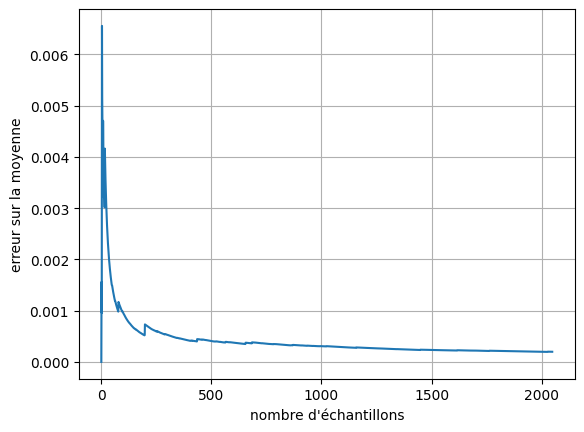

In [83]:
eps =10**(-3)
H_loc = np.array(H_loc(eps), dtype=float)
Ns = len(H_loc)
cum_sum = np.cumsum(H_loc)
cum_sum2 = np.cumsum(H_loc**2)

k = np.arange(1, Ns+1)
means = cum_sum / k
var_unb = (cum_sum2 - k*means**2) / np.maximum(1, k-1)
stderr = np.sqrt(var_unb / k)

plt.plot(k, stderr)
plt.xlabel("nombre d'échantillons")
plt.ylabel("erreur sur la moyenne")
plt.grid(True)
plt.show()


C:\Users\mouts\AppData\Local\Temp\ipykernel_15720\826225019.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.array(H_loc(eps), dtype=float)   # H_loc doit renvoyer un échantillon pour cet eps


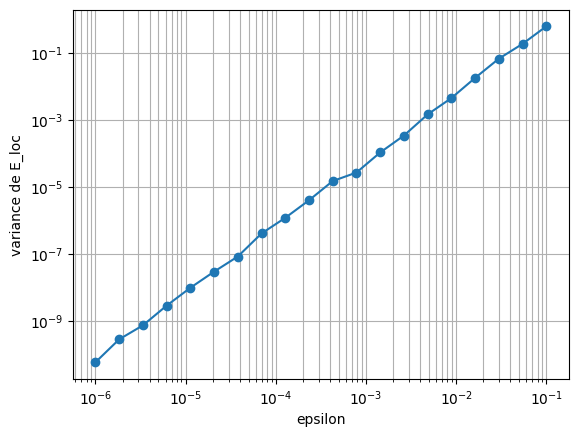

In [ ]:
eps_grid = np.logspace(-6, -1, 20)  

vars_eps = []

for eps in eps_grid:
    x = np.array(H_loc(eps), dtype=float)   
    var_unb = np.var(x, ddof=1)             
    vars_eps.append(var_unb)

plt.loglog(eps_grid, vars_eps, marker='o')
plt.xlabel("epsilon")
plt.ylabel("variance de E_loc")
plt.grid(True, which='both')
plt.show()


### TODO
- plot the error of mean as a function of the number of samples. In the case of random states, the error will be very large.
- try to add a small perturbation $\ket{\psi} = \ket{\psi_0} + \varepsilon \ket{\phi}$ to the ground state and plot the variance as a function fo the perturbation $\varepsilon$. Here the states should be normalized beforehand.